# Multi-class Modeling

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Training Set](#TrainingSet)
2. [Classifiers](#Classifiers)
3. [Feature Engineering](#Feature-Engineering)
    1. [Bag-of-Words](#Bag-of-Words)
    2. [Null Accuracy](#Null-Accuracy)
    3. [Optimizing BoW](#Optimizing-BoW)
4. [Cross-Validation](#Cross-Validation)
5. [Hyperparameter Tuning](#Hyperparameter-Tuning)
6. [Dataset-Preparation](#Dataset-Preparation)
    1. [Text Cleaning](#Text-Cleaning)
    2. [Noun Chunk Extraction](#Noun-Chunk-Extraction)
7. [Predictions](#Predictions)

## Training Set

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import pandas as pd                # Data processing
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline

In [3]:
df = pd.read_csv('noun_chunks_classified.csv')
df['type'].value_counts()

not_skill     3406
hard_skill     524
soft_skill      70
Name: type, dtype: int64

As we can see the data set is not balanced. By far the most records describe the not_skill feature. Let's try some undersampling on the most available data. What is also important to say here, is that we could try to oversample the lowest class in a future edit.

<AxesSubplot: >

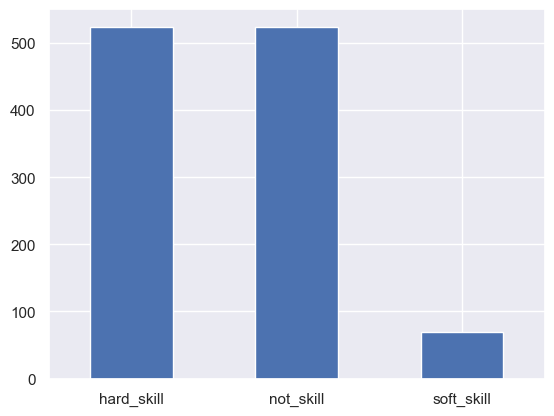

In [4]:
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=len(df[df['type'] == "hard_skill"]))

df = pd.concat([df_skills, df_not_skills], ignore_index=True)

df['type'].value_counts().plot(kind='bar', rot=0)

Let's split the dataset into train and test sets for some initial fitting.

In [5]:
from sklearn.model_selection import train_test_split

# Extract features and prediction vectors
X = df['chunks']
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((782,), (336,))

## Classifiers

For this part I am going to train various classifiers and compare the training results. In detail the classifiers I will use are:

1. Multinomial Naive Bayes
2. Support Vector Machine
3. Linear Support Vector Machine
4. Random Forest
5. Logistic Regression

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

models = [
    MultinomialNB(),
    SVC(),
    LinearSVC(dual=False),
    RandomForestClassifier(),
    LogisticRegression()
]

## Feature Engineering

### Bag-of-Words

The `Bag-of-Words` model is a simplified representation of corpus collection, often used in natural language processing. It is the way to transform text into numeric representations, used by the classifiers. The most basic form of `BoW` is to represent text based on term frequency. The issue here is that the larger the matrix, the larger the feature matrix.

For this reason in information retrieval there is a better approach called `tf-idf` (term frequency–inverse document frequency). This model reflects the importance of a word in a document of the corpus.

In [7]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

print(np.shape(X_train_vec), np.shape(X_test_vec))

(782, 918) (336, 918)


Let's try to fit our models and measure the initial accuracy scores of the train and test sets.

In [8]:
measurements = []

for model in models:
    model.fit(X_train_vec, y_train)
    score_train = model.score(X_train_vec, y_train)
    score_test = model.score(X_test_vec, y_test)
    measurements.append([model.__class__.__name__, score_train, score_test])

results = pd.DataFrame(measurements, columns=['model', 'train_accuracy', 'test_accuracy'])
results

,model,train_accuracy,test_accuracy
0,MultinomialNB,0.897698,0.642857
1,SVC,0.974425,0.818452
2,LinearSVC,0.991049,0.803571
3,RandomForestClassifier,0.998721,0.809524
4,LogisticRegression,0.934783,0.836310


### Null Accuracy

Let's check the most basic comparison of our models against the null accuracy score. This score will tell us if the models perform better than just selecting the most frequent class every time.

In [9]:
# Null Accuracy
class_choices = y_test.value_counts()
null_accuracy = class_choices[0] / sum(class_choices)

print('Null accuracy score: {0:0.4f}\n'.format(null_accuracy))

Null accuracy score: 0.5179



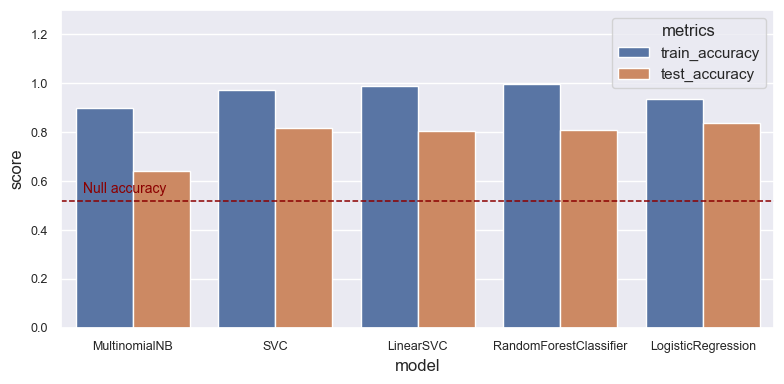

In [10]:
plt.figure(figsize=(8,4))

data_transformed = results.melt(id_vars='model', value_name='score', var_name='metrics')

metrics_plt = sns.barplot(data=data_transformed, x='model', y='score', hue='metrics')
metrics_plt.tick_params(labelsize=9)

plt.axhline(y=null_accuracy, ls='--', c='darkred', linewidth=1.1)
plt.text(-0.35, 0.55, 'Null accuracy', c='darkred', size='small')
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()

### Optimizing BoW

We can observe that all of the models perform way better than the "null accuracy" score. It means we have good first predictions.

Before we move on, let's see if we can improve these accuracies by fine tuning the TfIdf vectorizer.
One way is to increase the amount of n-grams to include more combinations than just unigrams.
We will also use the option `sublinear_tf` which is a form of penalty indicating that when a term is X times more frequent, it shouldn't be X times as important.

The scoring metric we are going to use is the `f1_score` function. As this is a multi-class setting, we will need to use one of these settings:

- weighted (favours the majority class)
- micro (no favoring)
- macro (bigger penalty due to poor performance on minority classes)

For this example we will use the micro setting.

In [11]:
from sklearn.metrics import f1_score

for n in range(1,11):
    # convert training data to bag of words
    vectorizer  = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, n), stop_words='english')
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)
    
    # train model and generate predictions
    scores = []
    for model in models:
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
    
        # compute f-1 score
        score = np.round(f1_score(y_test, y_pred, average='micro'), 5)
        scores.append(score)
    print('F1-score of n-gram range {}:\t {}'.format((1,n), scores))

F1-score of n-gram range (1, 1):	 [0.63988, 0.80952, 0.80655, 0.8125, 0.82738]
F1-score of n-gram range (1, 2):	 [0.64286, 0.80357, 0.82143, 0.79762, 0.82738]
F1-score of n-gram range (1, 3):	 [0.64583, 0.80357, 0.81845, 0.79464, 0.81548]
F1-score of n-gram range (1, 4):	 [0.64583, 0.80952, 0.81548, 0.8006, 0.81845]
F1-score of n-gram range (1, 5):	 [0.64583, 0.80357, 0.81548, 0.78571, 0.81548]
F1-score of n-gram range (1, 6):	 [0.64881, 0.80357, 0.81548, 0.79464, 0.81548]
F1-score of n-gram range (1, 7):	 [0.64881, 0.80357, 0.81548, 0.8006, 0.81548]
F1-score of n-gram range (1, 8):	 [0.64881, 0.80357, 0.81845, 0.79762, 0.81548]
F1-score of n-gram range (1, 9):	 [0.64881, 0.80357, 0.81845, 0.78274, 0.81548]
F1-score of n-gram range (1, 10):	 [0.64881, 0.80357, 0.81845, 0.80357, 0.81548]


As we can see the best value for n in most models seems to be 3. Let's make this selection.

In [12]:
vectorizer  = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3), stop_words='english')
X_vec = vectorizer.fit_transform(X)

## Cross-Validation

Instead of utilizing the simple technique of *train-test-split*, another common practice is called **k-fold Cross-Validation** and aims to reduce overfitting. Cross-validation is a resampling procedure, which splits the data into **k** sets, and uses each set interchangably as the test set. It usually results to a less biased and less optimistic estimate of out models.

One popular value for **k** is the 10-fold Cross Validation.

In [13]:
from sklearn.model_selection import cross_val_score

# Get cross validated scores for input models
def get_cross_val_scores(models, x, y):
    measurements = []
    for model in models:
        scores = cross_val_score(model, x, y, cv = 10, scoring = 'f1_micro')

        for i, score in enumerate(scores):
            measurements.append((model.__class__.__name__, i, score))

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'score'])
    return results

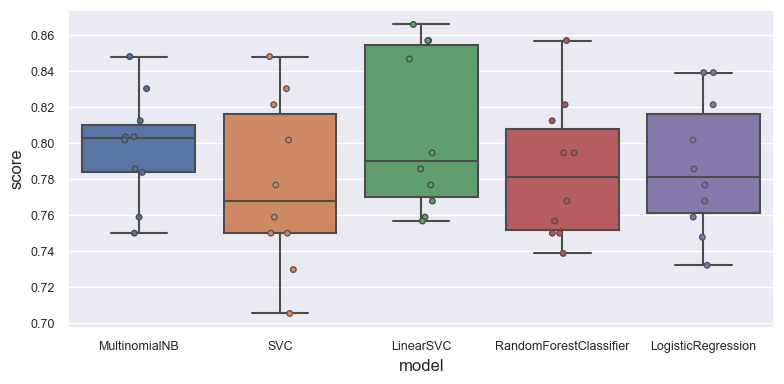

In [14]:
cv_results = get_cross_val_scores(models, X_vec, y)

plt.figure(figsize=(8,4))

cs_metrics_bxplt = sns.boxplot(x='model', y='score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='score', hue='model', data=cv_results,
                                 size=4, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

In [15]:
cv_results.groupby('model').score.mean().sort_values(ascending=False)

model
LinearSVC                 0.806789
MultinomialNB             0.797844
LogisticRegression        0.787098
RandomForestClassifier    0.784371
SVC                       0.777260
Name: score, dtype: float64

## Hyperparameter Tuning

The models we instatiated so far, could be potentially further improved by fine tuning their respective hyperparameter values. One process to perform hyperparameter tuning is called GridSearchCV, which exhaustively checks each pair of values to find the optimal. We will feed some sets of values to be checked into this process, as there is no way to find the best values for each hyperparameter in advance.

In [16]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter configurations for GridSearch
params_mnb = {'alpha': np.arange(0.01, 1, 0.01)}

params_svc = {'random_state': [0], 'C': np.arange(0.01, 1, 0.01), 'kernel': ['rbf','linear'], 'gamma': ['scale','auto'],
              'probability': [True,False], 'decision_function_shape': ['ovo','ovr']}

params_lsv = {'random_state': [0], 'dual': [True], 'C': np.arange(0.01, 1, 0.01), 'multi_class': ['ovr','crammer_singer']}

params_rfc = {'random_state': [0], 'n_jobs': [-1], 'n_estimators': [50,100,200], 'min_samples_leaf': [1,2],
              'max_depth': [None,5], 'min_samples_split': [2,5], 'oob_score': [True,False], 'warm_start': [True,False]}
              
params_lrc = {'random_state': [0], 'n_jobs': [-1], 'C': np.arange(0.01, 1, 0.01), 'warm_start': [True,False],
              'multi_class': ['multinomial']}

# Create the list of grid search models
grid_searches = [
    GridSearchCV(MultinomialNB(),          params_mnb, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(SVC(),                    params_svc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(LinearSVC(),              params_lsv, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(RandomForestClassifier(), params_rfc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(LogisticRegression(),     params_lrc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1)
]

In [17]:
import time

# Try to fit the models using the Grid Search and update models with optimal hyperparameters
index = 0
gs_scores = []
for gs in grid_searches:
    model_name = models[index].__class__.__name__
    
    start = time.time()
    gs.fit(X_vec, y)
    end = time.time()
    
    print(f'GridSearch for {model_name} finished after {round(end-start, 2)} seconds. Best parameters found:')
    print(f'{gs.best_params_}\n')
    
    models[index] = gs.best_estimator_
    gs_scores.append((model_name, round(gs.best_score_, 4)))
    index += 1
gs_scores = pd.DataFrame(gs_scores, columns=['model', 'score'])

GridSearch for MultinomialNB finished after 5.05 seconds. Best parameters found:
{'alpha': 0.35000000000000003}

GridSearch for SVC finished after 899.59 seconds. Best parameters found:
{'C': 0.98, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'random_state': 0}

GridSearch for LinearSVC finished after 6.35 seconds. Best parameters found:
{'C': 0.8200000000000001, 'dual': True, 'multi_class': 'crammer_singer', 'random_state': 0}

GridSearch for RandomForestClassifier finished after 231.44 seconds. Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'warm_start': True}

GridSearch for LogisticRegression finished after 50.69 seconds. Best parameters found:
{'C': 0.98, 'multi_class': 'multinomial', 'n_jobs': -1, 'random_state': 0, 'warm_start': True}



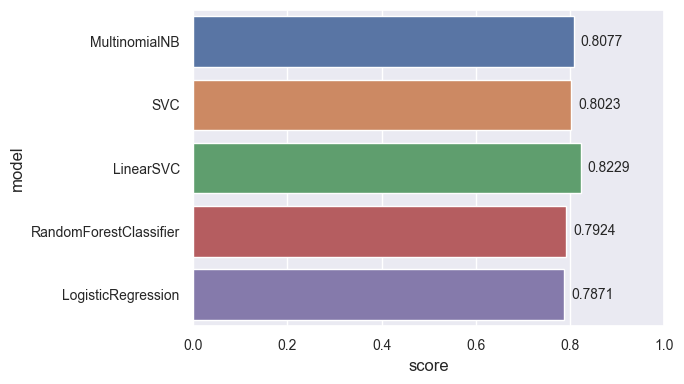

In [18]:
plt.figure(figsize=(7,4))

metrics_plt = sns.barplot(gs_scores, x='score', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)

plt.xlim(0, 1)
plt.tight_layout()
plt.show()

We can see that almost all models had a very small increase in their performance. The best models seem to be Multinomial Naive Bayes and LinearSVC.

## Dataset Preparation

In [19]:
from modeling.database import MongoDB
db = MongoDB()
df = pd.DataFrame(list(db.get_all_documents()))

### Text cleaning

In [20]:
gr_chars = "ΑαΆάΒβΓγΔδΕεΈέΖζΗηΉήΘθΙιΊίΚκΛλΜμΝνΞξΟοΌόΠπΡρΣσςΤτΥυΎύΦφΧχΨψΩωΏώ"

def remove_greek(desc):
    for char in gr_chars:
        if char in desc:
            desc = desc.replace(char, '')
    return desc

# Remove Greek words as the ads were meant for Greece
df['description'] = df['description'].apply(lambda x: remove_greek(x))

# Remove usual examples
df['description'] = df['description'].str.replace('e.g.', '', regex=False)
df['description'] = df['description'].str.replace('i.e.', '', regex=False)

# Remove e-mails
df['description'] = df['description'].str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b', '', regex=True)

# Remove links
df['description'] = df['description'].str.replace(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', regex=True)

# Remove hashtags
df['description'] = df['description'].str.replace(r'\B#([a-z0-9]{1,})', '', regex=True)

# Remove special characters, new lines and whitespaces
df['description'] = df['description'].str.replace(r'[^\w\s+#]', ' ', regex=True)
df['description'] = df['description'].str.replace(r'(\s{2,})|(\n+)', ' ', regex=True)

### Noun Chunk Extraction

In [21]:
import spacy

nlp = spacy.load("en_core_web_sm")

noun_phrases = []
for doc in nlp.pipe(df['description'].astype('unicode').values, batch_size=50, n_process=6):
    assert doc.has_annotation("DEP")
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text)

# Swap the following so that the set does not include duplicate phrases
#nouns_phrases_set = list(set(noun_phrases))
nouns_phrases_set = list(noun_phrases)

df = pd.DataFrame(nouns_phrases_set, columns=["chunks"])
len(df)

50612

## Predictions

In [22]:
X_dataset_vec = vectorizer.transform(df['chunks'])
X_dataset_vec.shape

(50612, 4398)

In [23]:
best_model = models[gs_scores['score'].idxmax()]

y_pred = best_model.predict(X_dataset_vec)
df['prediction'] = y_pred

Let's use the `CountVectorizer` model to exctract the most common "hard_skill" unigrams and bigrams from our predictions.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word', stop_words='english')
sparse_matrix = count_vectorizer.fit_transform(df[df['prediction']==1]['chunks'])

frequencies = sum(sparse_matrix).toarray()[0]

ngrams = pd.DataFrame(frequencies, index=count_vectorizer.get_feature_names_out(), columns=['frequency'])
ngrams = ngrams.sort_values(by='frequency', ascending=False)
ngrams[:25]

,frequency
data,2378
experience,1500
analytics,597
skills,443
science,419
sql,363
engineering,360
tools,325
learning,315
python,315


As we can see, our classifier was able to categorize a lot of useful tools out of the noun phrases.

In the next notebook, I will attempt to improve the classification task, by introducing neural network architectures.